In [1]:
from hmmlearn import hmm
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from matplotlib import cm, pyplot as plt
import pickle
import warnings
from math import sqrt
import numpy
import pyedflib
import numpy as np
import time
start_time = time.time()
np.random.seed(111)


In [2]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 

In [3]:
g = pyedflib.EdfReader('sample-data/SC4001E0-PSG.edf')
n = g.signals_in_file
signal_labels = g.getSignalLabels()
sigbufs = np.zeros((n, g.getNSamples()[0]))
for i in np.arange(n):
    len_sig = len(g.readSignal(i))
    sigbufs[i, :len_sig] = g.readSignal(i)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.56079602242 seconds ---


(115, 7950000)


AttributeError: 'numpy.ndarray' object has no attribute 'time'

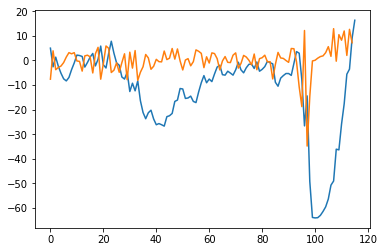

In [34]:
# transform data to be stationary
diff_values = difference(sigbufs[0][:116], 1)
plt.plot(range(sigbufs[0][:116].shape[0]), sigbufs[0][:116])
plt.plot(range(len(diff_values)), diff_values)
print(len(diff_values), sigbufs[0].shape[0])
print("--- %s seconds ---" % (time.time() - start_time))
diff_values = diff_values.reshape(-1, 1)

In [7]:
model_3 = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter = 500, verbose=True).fit(diff_values)
print(model_3.means_)
print(model_3.covars_)
print(model_3.startprob_)
print(model_3.transmat_)
z = model_3.predict(diff_values)

[[ -4.39792084]
 [  1.09166532]
 [-12.48453477]]
[[[  5.66208823]]

 [[  5.56698474]]

 [[227.9706796 ]]]
[1.0000000e+000 1.3160476e-183 0.0000000e+000]
[[1.70404128e-01 8.29595872e-01 2.93131378e-14]
 [1.98515913e-01 7.88082176e-01 1.34019112e-02]
 [5.32190441e-57 1.10941719e-64 1.00000000e+00]]


/opt/conda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
         1        -336.8229             +nan
/opt/conda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
         2        -277.7612         +59.

[ 0  2 12 16 19 23 24 26 29 31 33 34 38 50 64 71 78 84]
[ 1  3  4  5  6  7  8  9 10 11 13 14 15 17 18 20 21 22 25 27 28 30 32 35
 36 37 39 40 41 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59 60 61
 62 63 65 66 67 68 69 70 72 73 74 75 76 77 79 80 81 82 83 85 86 87 88 89
 90 91 92 93]
[94 95 96 97 98]


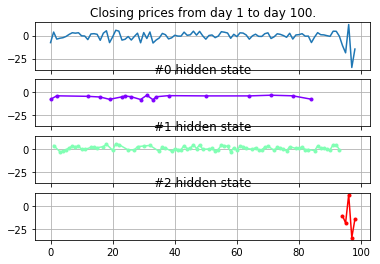

In [23]:
fig, axs = plt.subplots(model_3.n_components+1, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model_3.n_components))
time = np.arange(len(diff_values))
axs[0].plot(time, diff_values)
axs[0].set_title("Closing prices from day 1 to day 100.")
axs[0].grid(True)
diff_values = diff_values.reshape(99)
for i  in range(1,model_3.n_components+1):
    mask = z == i-1
    print(time[mask])
    axs[i].plot(time[mask], diff_values[mask], ".-", c=colours[i-1])
    axs[i].set_title("#{0} hidden state".format(i-1))

    axs[i].grid(True)

plt.show()

In [32]:
from sklearn.utils import check_random_state
L=15 # We would like to predict the following 15 days' trend
Niter = 10 # A hyper parameter of generating samples

warnings.filterwarnings('ignore')
eeg0 = diff_values
eeg2 = np.copy(diff_values)

startprob_cdf = np.cumsum(model_3.startprob_)
transmat_cdf = np.cumsum(model_3.transmat_, axis=1)
random_state = model_3.random_state

rs = check_random_state(None)

for l in range(L):
    eeg2 = np.append(eeg2,[0],axis=0) # Add a pair of empty (d,v)
    true_eeg = np.copy(eeg0[:len(diff_values)+l])
    true_eeg = true_eeg.reshape(-1,1)
    state_seq = model_3.predict(true_eeg)
    previous_state = state_seq[-1]
    
    maxLL = -1e10
    for n in range(Niter):
        currstate = (transmat_cdf[previous_state]> rs.rand() ).argmax() # Go through transmat to get a new state
       
        new_sample = model_3._generate_sample_from_state(currstate) # generate from the new state
        tmp_eeg = np.copy(true_eeg)
        tmp_eeg = np.append(tmp_eeg,[new_sample],axis=0) # Append the new_sample for score
        tmp_maxLL = model_3.score(tmp_eeg) # 
        if tmp_maxLL > maxLL :

                maxLL = tmp_maxLL
                eeg2[-1] = new_sample[0]
               

114
[ -7.5956044    3.93846154  -3.75091575  -2.81318681  -2.25054945
  -0.84395604   1.40659341   3.18827839   2.71941392   3.18827839
  -0.18754579  -0.37509158  -4.31355311   1.87545788   2.15677656
   1.5003663   -5.06373626   2.71941392   5.34505495  -7.5956044
  -1.31282051   5.90769231   4.96996337  -4.87619048  -3.93846154
  -0.93772894  -4.78241758  -0.84395604   2.71941392  -7.78315018
   3.37582418  -3.09450549   4.03223443  -8.06446886  -4.78241758
  -2.53186813   2.43809524   1.03150183  -3.56336996  -2.34432234
   0.46886447  -0.46886447  -0.56263736   3.84468864   0.37509158
   0.93772894   4.87619048   0.56263736   4.68864469  -0.18754579
  -3.84468864   0.18754579   0.75018315  -2.15677656  -0.46886447
   4.31355311   3.75091575   2.90695971  -2.90695971   1.5003663
  -1.03150183   3.09450549   2.81318681   0.75018315  -3.84468864
  -0.18754579   1.59413919  -0.75018315  -0.84395604   2.15677656
   3.09450549  -3.09450549  -1.21904762   2.06300366   1.40659341
   0.093

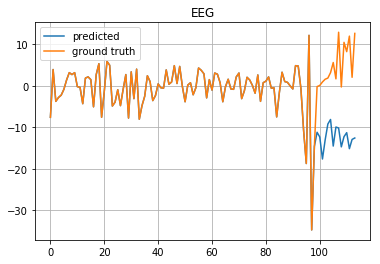

In [39]:
# The curve after day 100 is the predicted trend.

time2 = time = np.arange(len(eeg2))
print (len(time2))
plt.figure()
print(eeg2)
plt.plot(time2, eeg2)
plt.plot(time2, diff_values[:114])#[100:100+25])
plt.grid(True)
plt.legend(('predicted', 'ground truth'))
plt.title("EEG")
plt.show()